# Step 0: Explore the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Row                2167 non-null   int64
 1   Day.Of.Week        2167 non-null   int64
 2   Page.Loads         2167 non-null   int64
 3   Unique.Visits      2167 non-null   int64
 4   First.Time.Visits  2167 non-null   int64
 5   Returning.Visits   2167 non-null   int64
dtypes: int64(6)
memory usage: 101.7 KB


<Axes: xlabel='Row'>

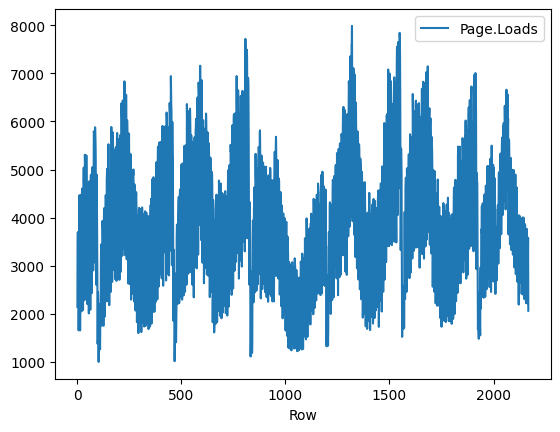

In [340]:
import pandas as pd
from matplotlib import pyplot as plt
df = pd.read_csv('daily-website-visitors.csv',thousands=',').dropna()
df.drop(['Day','Date'],axis=1,inplace=True)
#df['Date']=pd.to_datetime(df['Date'],format="%m/%d/%Y")
param = 'Page.Loads'
df.info()
ax=plt.gca()
df.plot(kind="line",x="Row",y=param,ax=ax)

<Axes: >

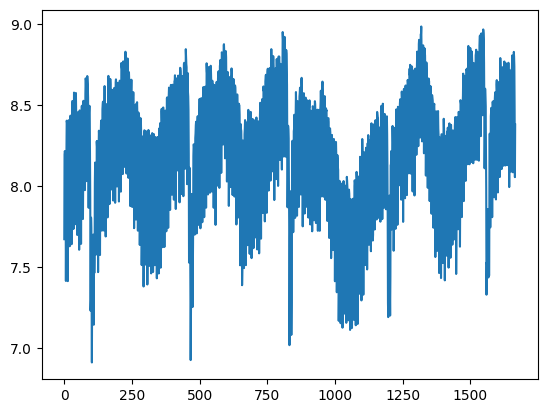

In [341]:
import numpy as np
df = np.log(df) # don't forget to transform the data back when making real predictions
df_train[param].plot()

In [342]:
msk = (df.index < len(df)-500)
df_train = df[msk].copy()
df_test = df[~msk].copy()


# Step 1: Check for stationarity of time series

## Method #1: ACF and PACF 

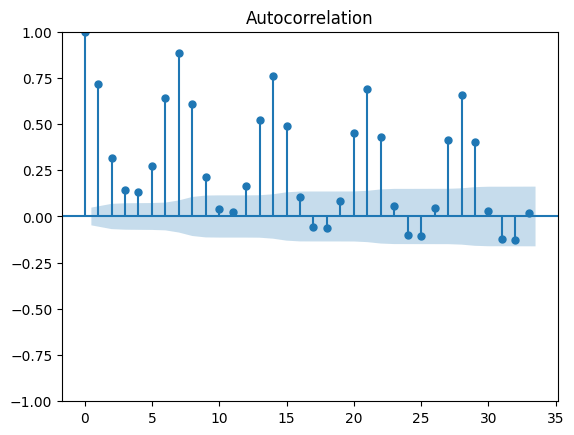

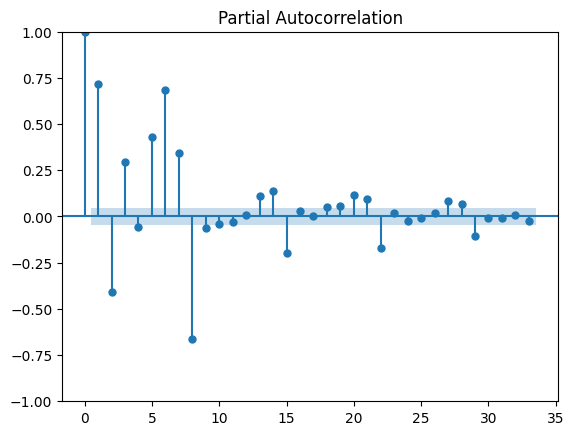

In [343]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train[param])

pacf_original = plot_pacf(df_train[param])

## Method #3: ADF test

In [344]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train[param])
print(f'p-value: {adf_test[1]}')

p-value: 0.00022288390389911994


## Transform to stationary: differencing

<Axes: >

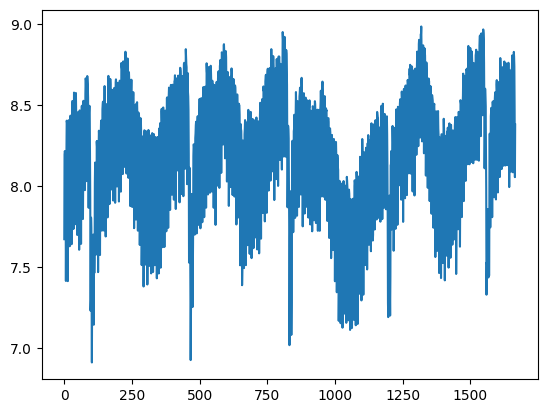

In [345]:
#No differencing required since already stationary
df_train_diff = df_train
while(adf_test[1]>0.05):
    df_train_diff = df_train.diff().dropna()
df_train_diff[param].plot()


In [346]:
adf_test = adfuller(df_train_diff[param])
print(f'p-value: {adf_test[1]}')

p-value: 0.00022288390389911994


# Step 2: Determine ARIMA models parameters p, q

# Step 3: Fit the ARIMA model

In [347]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train[param], order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Page.Loads   No. Observations:                 1667
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 -17.660
Date:                Wed, 11 Oct 2023   AIC                             41.321
Time:                        22:08:18   BIC                             57.575
Sample:                             0   HQIC                            47.344
                               - 1667                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3110      0.022     14.157      0.000       0.268       0.354
ar.L2         -0.4765      0.025    -18.869      0.000      -0.526      -0.427
sigma2         0.0598      0.002     25.125      0.0

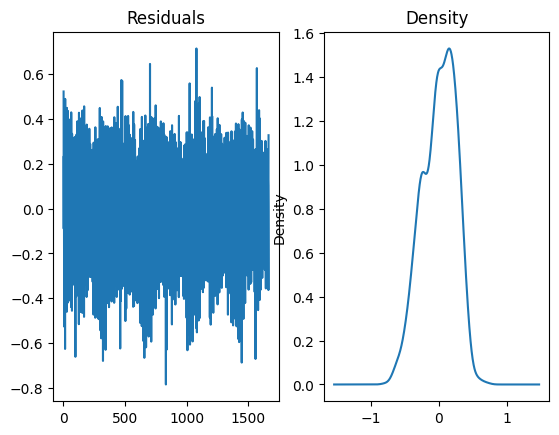

In [348]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

In [349]:
forecast_test = model_fit.forecast(len(df_test['Page.Loads']))

df['forecast_manual'] = [None]*len(df_train['Page.Loads']) + list(forecast_test)

df[['Page.Loads','forecast_manual','forecast_auto']].plot()

KeyError: "['forecast_auto'] not in index"

# Step 4: Make time series predictions

<Axes: >

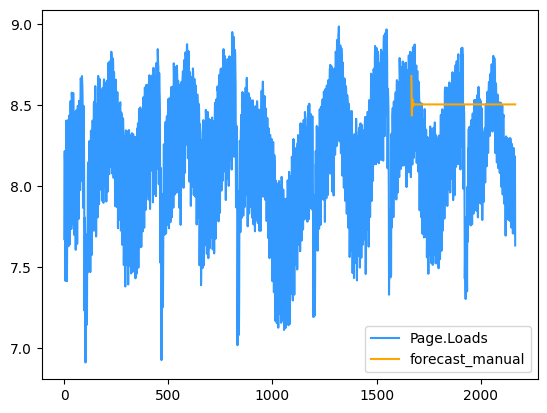

In [350]:
forecast_test = model_fit.forecast(len(df_test))

df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df[[param,'forecast_manual']].plot(color=['#3399ff','orange'])



# Optional: Auto-fit the ARIMA model

In [333]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train[param], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [334]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1667
Model:               SARIMAX(5, 1, 0)   Log Likelihood                 791.511
Date:                Wed, 11 Oct 2023   AIC                          -1569.021
Time:                        22:06:08   BIC                          -1531.094
Sample:                             0   HQIC                         -1554.966
                               - 1667                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.004      0.286      0.775      -0.007       0.009
ar.L1         -0.1089      0.018     -6.218      0.000      -0.143      -0.075
ar.L2         -0.6338      0.016    -39.985      0.000      -0.665      -0.603
ar.L3         -0.4069      0.019    -20.883      0.000      -0.445      -0.369
ar.L4         -0.3334      0.016    -20.716      0.000      -0.365      -0.302
ar.L5         -0.7004      0.014    -49.661      0.000      -0.728      -0.673
sigma2         0.0226      0.001     37.310      0.000       0.021       0.024
===================================================================================
Ljung-Box (L1) (Q):                 105.69   Jarque-Bera (JB):               327.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.42
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

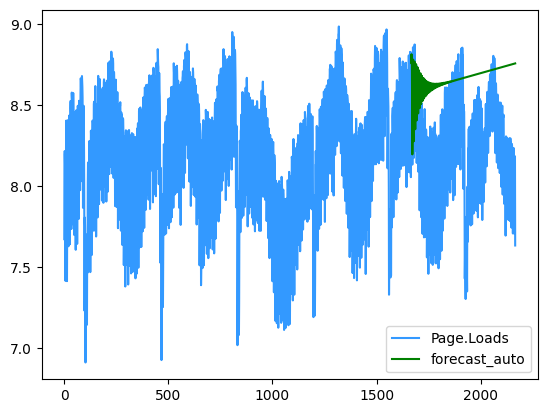

In [351]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test[param]))
df['forecast_auto'] = [None]*len(df_train[param]) + list(forecast_test_auto)

df[[param,'forecast_auto',]].plot(color=['#3399ff','green'])

## Step #5: Evaluate model predictions

<Axes: >

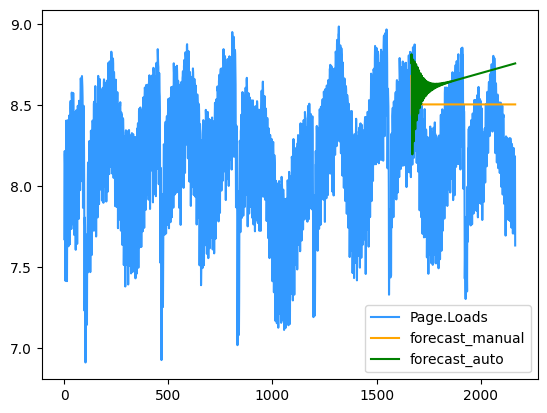

In [352]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test[param]))
df['forecast_auto'] = [None]*len(df_train[param]) + list(forecast_test_auto)

df[[param,'forecast_manual','forecast_auto']].plot(color=['#3399ff','orange','green'])

In [358]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test[param], forecast_test)
mape = mean_absolute_percentage_error(df_test[param], forecast_test)
mse = mean_squared_error(df_test[param], forecast_test)
rmse = np.sqrt(mean_squared_error(df_test[param], forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'mse - manual: {mse}')
print(f'rmse - manual: {rmse}')


mae - manual: 0.29704959231892286
mape - manual: 0.03701199782139722
mse - manual: 0.15254232756192615
rmse - manual: 0.39056667492494307


In [356]:
mae = mean_absolute_error(df_test[param], forecast_test_auto)
mape = mean_absolute_percentage_error(df_test[param], forecast_test_auto)
mse = mean_squared_error(df_test[param], forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test[param], forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'mse - auto: {mse}')
print(f'rmse - auto: {rmse}')

mae - auto: 0.4017289158308398
mape - auto: 0.04997490341769592
mse - auto: 0.24986339528970478
rmse - auto: 0.49986337662375785


## Bounce rate analysis

In [361]:
total_page_loads = df['Page.Loads'].sum()
total_bounces = df['First.Time.Visits'].sum()

bounce_rate = (total_bounces / total_page_loads) * 100
print(f"Bounce Rate: {bounce_rate:.2f}%")

Bounce Rate: 93.56%


# Other suggestions